In [1]:
%cd ..
import os
from sklearn.datasets import load_digits
from sklearn.preprocessing import OneHotEncoder
from skimage import io, transform
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from src.linear import Linear
from src.loss import *
from src.activation import TanH, Sigmoid, Softmax, ReLU, Softplus
from src.encapsulation import Sequential, Optim
np.random.seed(42)

/mnt/48566869-e5b1-482e-907d-2c513d1afe25/Documents/NeuralNetworksDIY


jouer avec les hpyerparam
espace latent
les initialisation 
plein de loss 
qu'est ce qui boost les perfs 

# Débruitage d'image plus petite

fashion mnist

In [5]:
def load_data(rootdir, trim: float = 0.5):
    def normalize_batch_image(X):
        mn = np.min(X)
        mx = np.max(X)
        X_norm = (X - mn) * (1.0 / (mx - mn))
        return X_norm

    train = pd.read_csv(os.path.join(rootdir, "fashion-mnist_train.csv"))
    y_train = train["label"].values
    X_train = train.drop(columns="label").values

    test = pd.read_csv(os.path.join(rootdir, "fashion-mnist_test.csv"))
    y_test = test["label"].values
    X_test = test.drop(columns="label").values

    trim_train = int(len(X_train) * trim)
    # trim_test = int(len(X_test) * trim)
    trim_test = int(len(X_test))

    # Normalization + trimming
    X_train = normalize_batch_image(X_train[:trim_train, :])
    X_test = normalize_batch_image(X_test[:trim_test, :])
    y_train = normalize_batch_image(y_train[:trim_train])
    y_test = normalize_batch_image(y_test[:trim_test])

    return (X_train, X_test, y_train, y_test)


rootdir = "./data/fashion-mnist/"
X_train, X_test, y_train, y_test = load_data(rootdir, trim=0.1)

y_train_oh = OneHotEncoder().fit_transform(y_train.reshape(-1, 1)).toarray()
y_test_oh = OneHotEncoder().fit_transform(y_test.reshape(-1, 1)).toarray()
nb_class = y_train_oh.shape[1]
batch_size = 64


 20%|██        | 1/5 [00:06<00:27,  6.84s/it]

[Train] Epoch [1], Loss = 59.8859, Score = 0.0027
[Test] Epoch [1], Loss = 96353.0982, Score = 0.0025


 40%|████      | 2/5 [00:14<00:21,  7.23s/it]

[Train] Epoch [2], Loss = 42.1100, Score = 0.0070
[Test] Epoch [2], Loss = 73191.7087, Score = 0.0096


 60%|██████    | 3/5 [00:21<00:14,  7.31s/it]

[Train] Epoch [3], Loss = 33.3600, Score = 0.0132
[Test] Epoch [3], Loss = 61101.6482, Score = 0.0111


 80%|████████  | 4/5 [00:30<00:07,  7.76s/it]

[Train] Epoch [4], Loss = 28.8267, Score = 0.0159
[Test] Epoch [4], Loss = 54765.2065, Score = 0.0126


100%|██████████| 5/5 [00:38<00:00,  7.62s/it]

[Train] Epoch [5], Loss = 26.2921, Score = 0.0154
[Test] Epoch [5], Loss = 50804.9892, Score = 0.0136


<Axes: xlabel='epoch', ylabel='loss'>

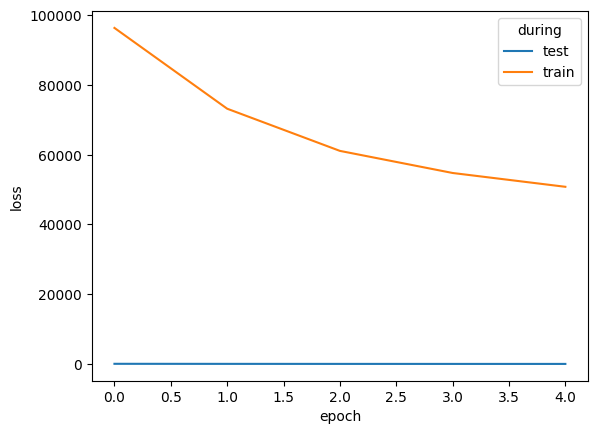

In [9]:
encoder = [
    Linear(784, 64, init_type="xavier_uniform"),
    TanH(),
]
decoder = [Linear(64, 784, init_type="xavier_uniform"), Sigmoid()]
net = Sequential(*(encoder + decoder))
optimizer = Optim(net.reset(), MSELoss(), eps=1e-3)
result_df = optimizer.SGD_eval(
    X_train, X_train, batch_size, 5, test_size=0.33, return_dataframe=True
)

_, ax = plt.subplots()
loss_long_df = pd.melt(
    result_df,
    id_vars="epoch",
    value_vars=["loss_test", "loss_train"],
    value_name="loss",
    var_name="during",
).replace({"loss_test": "test", "loss_train": "train"})
sns.lineplot(data=loss_long_df, x="epoch", y="loss", hue="during", ax=ax)


In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler


class AutoEncoder:
    def __init__(self, encoder, decoder):
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, X):
        return self.decoder.forward(self.encoder.forward(X))

    def backward_update_gradient(self, X, delta):
        delta = self.decoder.backward_delta(self.encoder.forward(X), delta)
        return self.encoder.backward_delta(X, delta)

    def update_parameters(self, eps):
        self.encoder.update_parameters(eps)
        self.decoder.update_parameters(eps)


In [ ]:
optimizer = Optim(net.reset(), MSELoss(), eps=1e-3)
optimizer.SGD(X_train, X_train, batch_size, 10)


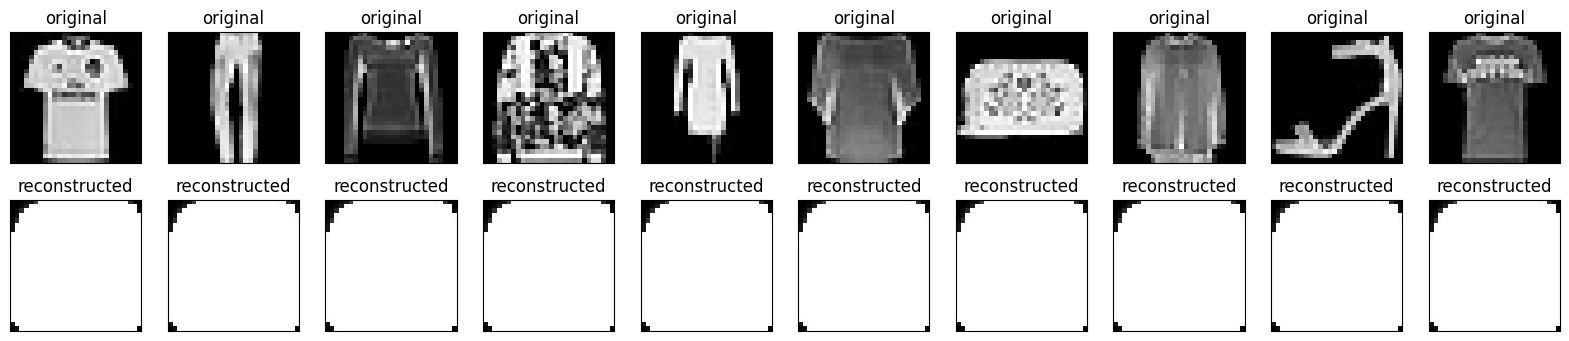

In [6]:
n = 10
decoded_imgs = net.forward(X_test)
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


# Débruitage d'image

Dataset : https://www.kaggle.com/datasets/uurdeep/cleaning-dirty-documents-unzipped

In [ ]:
def load_data(root_dir):
    size = (540, 420)
    X = []
    for filepath in os.listdir(root_dir + "/X"):
        imgpath = os.path.join(root_dir, "X", filepath)
        image = io.imread(imgpath)
        image = transform.resize(image, size).flatten()
        X.append(image)
    X = np.array(X)

    y = []
    for filepath in os.listdir(root_dir + "/y"):
        imgpath = os.path.join(root_dir, "y", filepath)
        image = io.imread(imgpath)
        image = transform.resize(image, size).flatten()
        y.append(image)
    y = np.array(y)

    return X, y


X, y = load_data("./data/dirty_documents")
print(X.shape)
print(y.shape)


In [ ]:
from src.convolution import *

encoder = [Conv1D(3, 1, 16, stride=2), ReLU(), Conv1D(3, 1, 8, stride=2), ReLU()]

decoder = [
    Conv1D(3, 1, 8, stride=2),
    ReLU(),
    Conv1D(3, 1, 16, 2),
    ReLU(),
    Conv1D(3, 1, 1),
    Sigmoid(),
]


net = Sequential(*(encoder + decoder))
optimizer = Optim(net, MSELoss(), eps=1e-1)
lossList = optimizer.SGD(X[:, :, np.newaxis], y, 144, 10)
print(lossList)
pd.Series(lossList).plot()


In [ ]:
batch_size = 32
d = 2  # Dim des entrées

X = np.random.random(size=(256, d))
y = np.random.choice([1], size=(256, 1))

encoder = [
    Linear(226800, 226800 // 8),
    TanH(),
    Linear(226800 // 8, 226800 / 16),
    TanH(),
    Linear(226800 / 16, 226800 / 32),
    TanH(),
]
decoder = [
    Linear(226800 / 16, 226800 / 32),
    TanH(),
    Linear(226800 / 8, 226800 / 16),
    TanH(),
    Linear(226800, 226800 / 8),
    Sigmoid(),
]
net = encoder + decoder
optimizer = Optim(net, CrossEntropyLoss(), eps=1e-1)
lossList = optimizer.SGD(X, y, batch_size, 10)
print(lossList)
pd.Series(lossList).plot()


In [ ]:
X.shape


**A faire avec une convolution**